In [1]:
# Importing the necessary libraries
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import sklearn
import scipy as sp
from sklearn.preprocessing import StandardScaler

In [2]:
# Calculating Cumulative Count Cut
def scaleCCC(x):
  return((x - np.nanpercentile(x, 2))/(np.nanpercentile(x, 98) - np.nanpercentile(x,2)))

def applyCCC(img):
  # Extracting individual bands(4,8,12) from the uploaded images
  band4 = img.GetRasterBand(1).ReadAsArray()
  band8 = img.GetRasterBand(2).ReadAsArray()
  band12 = img.GetRasterBand(3).ReadAsArray()
  ccc4 = scaleCCC(band4)
  ccc8 = scaleCCC(band8)
  ccc12 = scaleCCC(band12)
  # Creating a new image by combining the three bands
  return(np.dstack((ccc4,ccc8,ccc12)))

In [3]:
def process_image(img):
    data = img.ReadAsArray()
    data = np.moveaxis(data, 0, -1)
    rows, cols, bands = data.shape
    data_2d = data.reshape(rows*cols, bands)
    data_2d_scaled = scaler.fit_transform(data_2d)
    data_2d_scaled = np.nan_to_num(data_2d_scaled)
    return data_2d_scaled

In [4]:
# Defining Plot Function

def plot_image(plt_img):
  plt.figure()
  plt.imshow(plt_img)
  plt.show()

In [5]:
# Running the DBSCAN Algorithm
dbscan_model = DBSCAN(eps=0.050469945, min_samples=170)
scaler = StandardScaler()
all_images=[]
first = True
first2 = True

for i in range(3,7):
    # List of images
    images_list=[str(i)+ "_P_256.tif", str(i) +"_A_256.tif"]
    images = []
    # Opening the satellite images
    for img_name in images_list:
        img = gdal.Open('./ALL_FLOOD_256/'+ img_name)
        data_2d_scaled = process_image(img)

        modified_img = applyCCC(img)
        images.append(modified_img)

        if(first):
            train_image=data_2d_scaled
            first = False
        else:
            train_image = np.concatenate([data_2d_scaled, train_image], axis=0)

    all_images.extend(images)
    if (first2):
        combined_data = train_image
    else:
        combined_data = np.concatenate([combined_data, train_image], axis=0)

    dbscan_model.fit(combined_data)
    print(dbscan_model.labels_.shape)

(131072,)
(262144,)
(393216,)
(524288,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


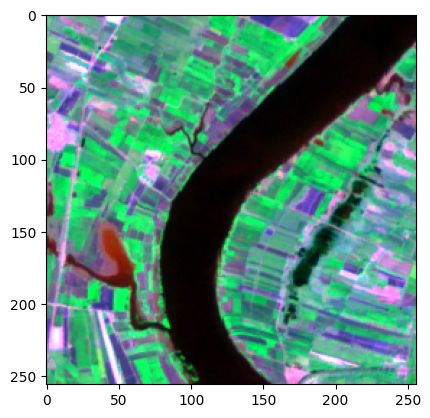

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


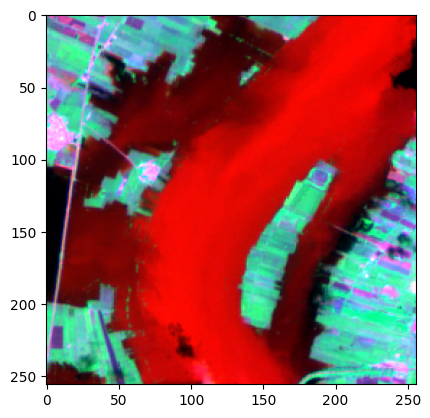

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


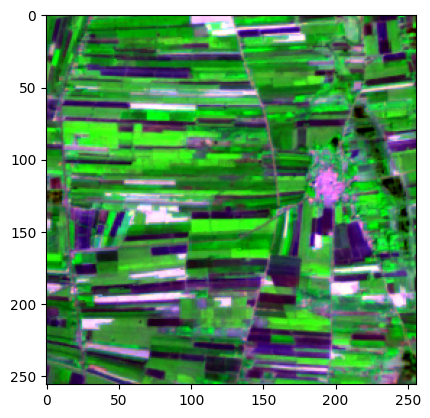

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


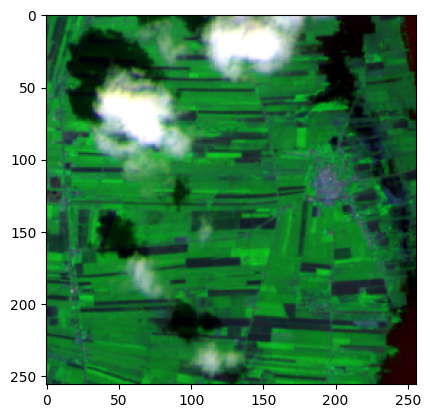

In [6]:
# Visualizing all the images
for img in all_images[:4]:
  plot_image(img)

In [7]:
# Opening the test images
imgP = gdal.Open("./ALL_FLOOD_256/2_P_256.tif")
imgA = gdal.Open("./ALL_FLOOD_256/2_A_256.tif")

before_img = applyCCC(imgP)
after_img = applyCCC(imgA)

X_before = process_image(imgP)
X_after = process_image(imgA)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


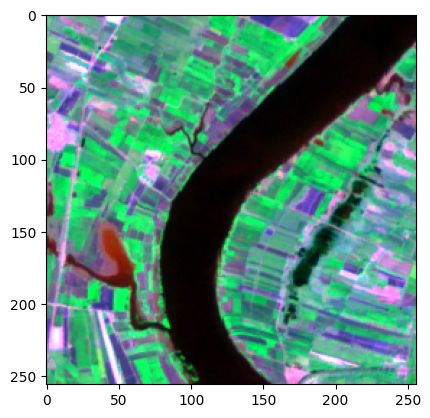

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


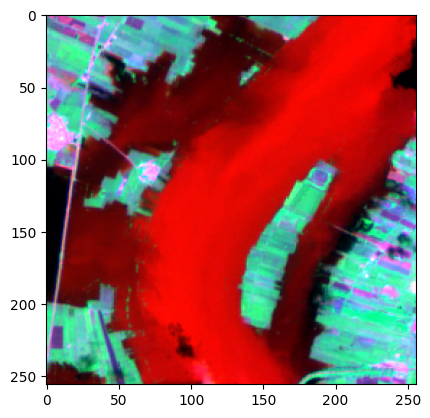

In [8]:
# Visualizing the before and after food images
plot_image(before_img)
plot_image(after_img)

In [9]:
# Running DBSCAN Algorithm on test before image

dbscan_before_labels = dbscan_model.fit_predict(X_before)
dbscan_before_labels_reshaped = dbscan_before_labels.reshape(256, 256)

In [10]:
# Running DBSCAN Algorithm on test after image

dbscan_after_labels = dbscan_model.fit_predict(X_after)
dbscan_after_labels_reshaped = dbscan_after_labels.reshape(256, 256)

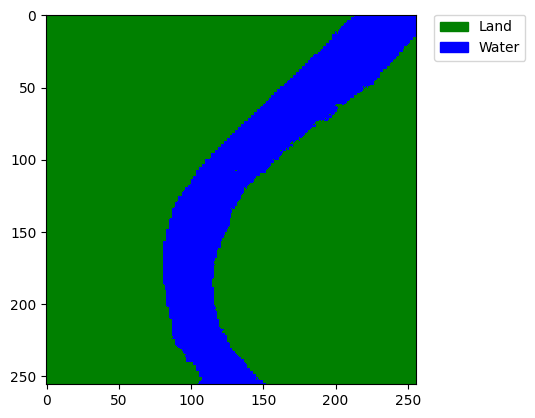

In [13]:
# Visualizing the clusters formed for pre-flood image

import matplotlib.patches as mpatches
import matplotlib.colors as colo

plt.figure()

custom = colo.ListedColormap(["green"] + ["blue"]*1)

im_before = plt.imshow(dbscan_before_labels_reshaped, cmap = custom)

values = np.unique(dbscan_before_labels_reshaped.ravel())

# Getting the colors of the values, according to the colormap used by imshow
colors = [im_before.cmap(im_before.norm(value)) for value in values]

# Creating a patch (proxy artist) for every color 
labels = ["Land"]+["Water"]*4
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(values)) ]
# Putting those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

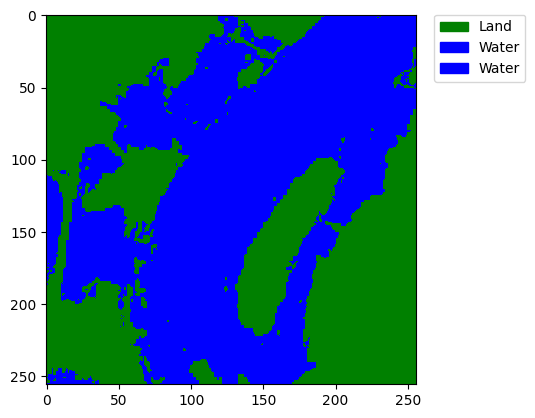

In [14]:
# Visualizing the clusters formed for post-flood image

plt.figure()

custom = colo.ListedColormap(["green"] + ["blue"]*2)

im_after = plt.imshow(dbscan_after_labels_reshaped, cmap = custom)

values = np.unique(dbscan_after_labels_reshaped.ravel())

# Getting the colors of the values, according to the colormap used by imshow
colors = [im_after.cmap(im_after.norm(value)) for value in values]

# Creating a patch (proxy artist) for every color 
labels = ["Land"]+["Water"]*8
patches = [ mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(values)) ]
# Putting those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [15]:
unique_labels = np.unique(dbscan_before_labels_reshaped)
num_clusters = len(unique_labels)  # subtract 1 to account for the noise points
print("Number of clusters formed:", num_clusters)

Number of clusters formed: 2


In [16]:
unique_labels = np.unique(dbscan_after_labels_reshaped)
num_clusters = len(unique_labels)  # subtract 1 to account for the noise points
print("Number of clusters formed:", num_clusters)

Number of clusters formed: 3


In [17]:
# Calculating water percentage for before image

arr_before = np.unique(dbscan_before_labels_reshaped, return_counts=True)
key_before, val_before = arr_before
water_before = val_before[1]/(sum(val_before)) * 100
print("%.2f" %water_before, "%")

17.39 %


In [20]:
# Calculating water percentage for after image
arr_after = np.unique(dbscan_after_labels_reshaped, return_counts=True)
key_after, val_after = arr_after
water_after = (val_after[1]+val_after[2])/(sum(val_after)) * 100
print("%.2f" %water_after, "%")

54.35 %


In [21]:
# Calculating Flood Increase

flood_increase = water_after - water_before
print("%.2f" %flood_increase, "%")

36.96 %


In [22]:
# Calculating silhouette score for comparision

z = sklearn.metrics.silhouette_score(X_after, dbscan_after_labels)
print("Accuracy:", ((z+1)/2)*100, "%")

Accuracy: 68.64780336618423 %
